In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *
import numpy as np
from jack_utils.my_metrics import *
import matplotlib.pyplot as plt
import random

from RWP import random_waypoint

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:GPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res

import math

def sigmoid(x):

    if x >= 0:
        z = math.exp(-x)
        sig = 1 / (1 + z)
        return sig
    else:
        z = math.exp(x)
        sig = z / (1 + z)
        return sig

In [3]:
nodes = 10
n = 500
_d = 3 # input dim
_k = 3 # k-nearest neighbors
_theta = 10
M = 100

# Build data

In [4]:
swapp = 0.1

In [5]:
# random weight for each node
W = np.random.randn(nodes, nodes*_d)

_X = np.random.randn(n, nodes*_d)
_Y = np.zeros((n, nodes))
S = [] # graphs for each step

initp = 0.3

s = np.zeros((nodes, nodes))

for i in range(nodes):
    for j in range(nodes):
        if i==j: 
            continue
        if np.random.rand() < initp:
            s[i,j] = 1
            
S.append(s)

In [6]:
for t in range(n):
    s = S[-1].copy()
    for i in range(nodes):
        ind = np.where(s[i]==1)[0]
        for idx in ind:
            _Y[t, i] += np.inner(W[i, idx*_d:idx*_d+_d], _X[t, idx*_d:idx*_d+_d])+np.inner(W[i, idx*_d:idx*_d+_d], _X[t, idx*_d:idx*_d+_d]**2)
#             print(s[i, idx]*np.inner(W[i, idx*_d:idx*_d+_d], _X[t, idx*_d:idx*_d+_d]))
#         _Y[t, i] += sigma * np.random.randn()
    s1 = zip(*np.where(s==1))
    for i1, j1 in s1:
        if np.random.rand() > swapp:
            continue
        i0, j0 = random.choice([(ii, jj) for (ii, jj) in list(zip(*np.where(s==0))) if ii != jj])
        s[i1,j1]=0
        s[i0,j0]=1
        
    S.append(s)
    
print(np.mean(_Y), np.std(_Y))

sigma = 0.01
_Y += sigma * np.random.randn(*_Y.shape)
    
print(np.mean(_Y), np.std(_Y))

np.savez('./data/er01', _X=_X, _Y=_Y)

-0.1448963913212776 5.753876888077778
-0.14475002105776624 5.753947660719843


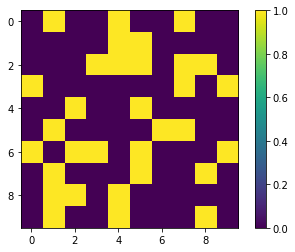

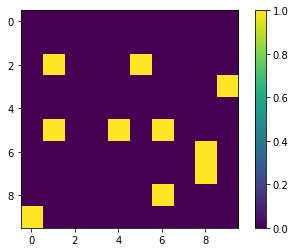

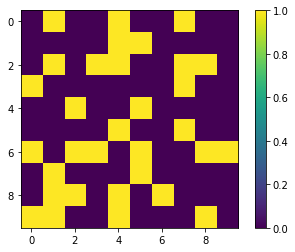

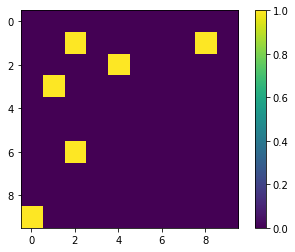

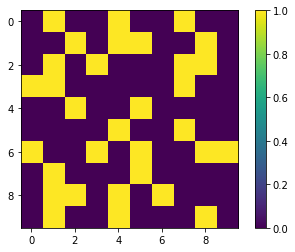

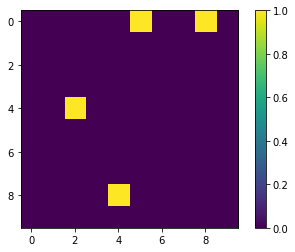

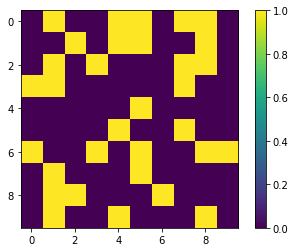

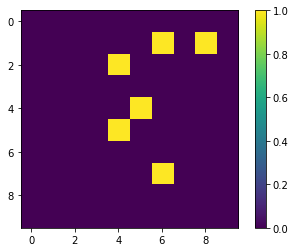

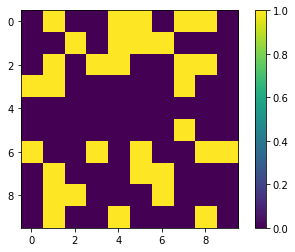

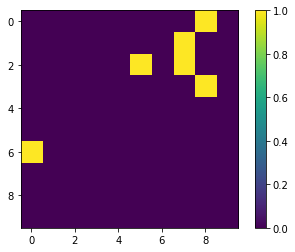

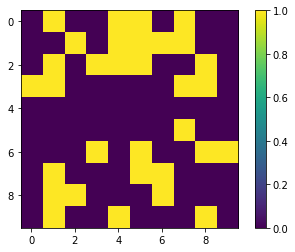

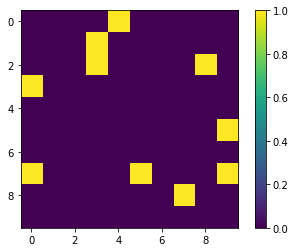

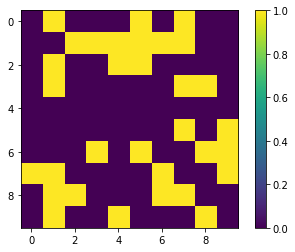

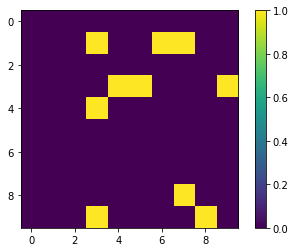

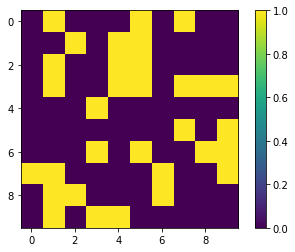

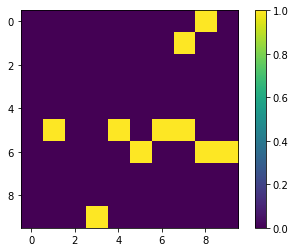

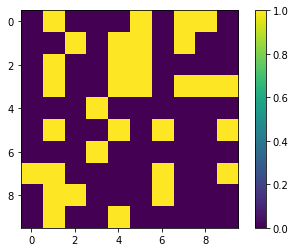

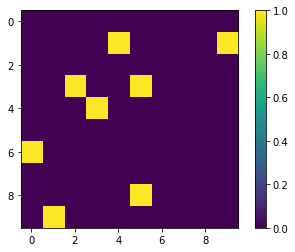

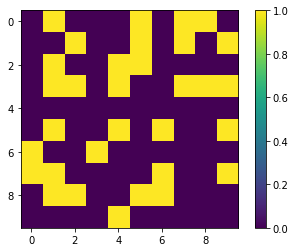

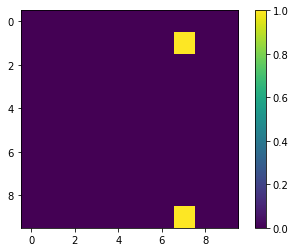

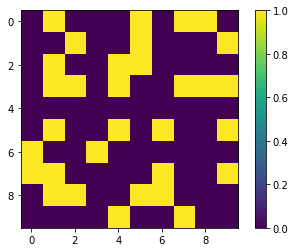

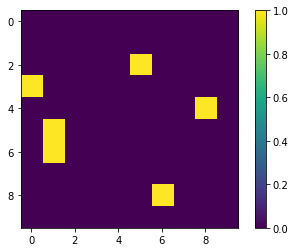

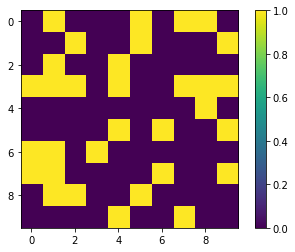

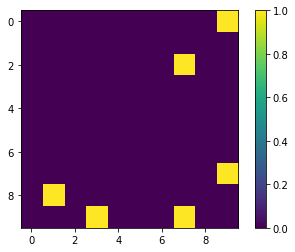

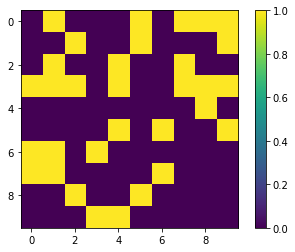

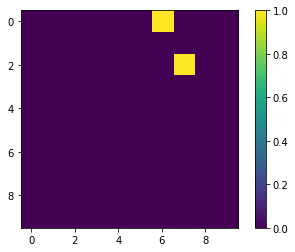

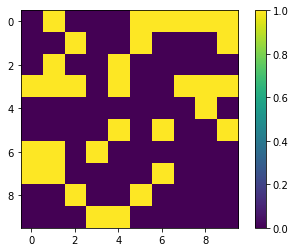

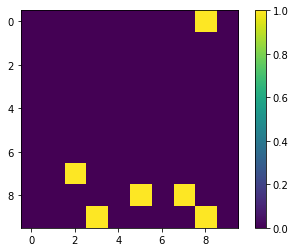

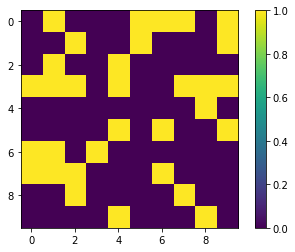

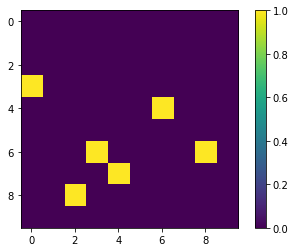

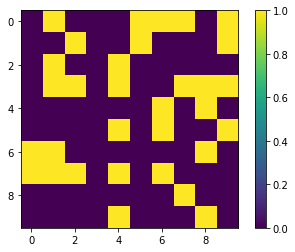

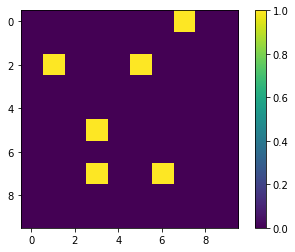

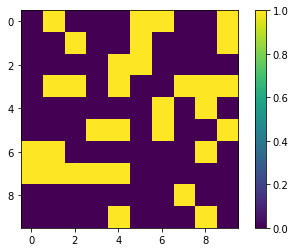

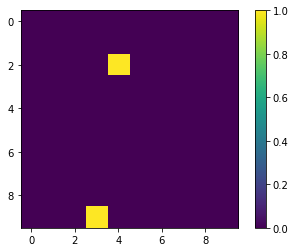

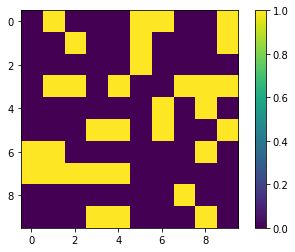

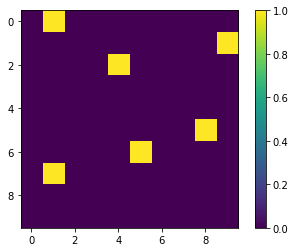

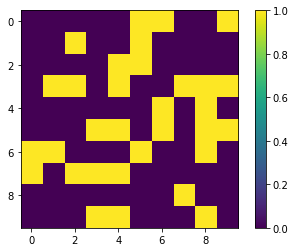

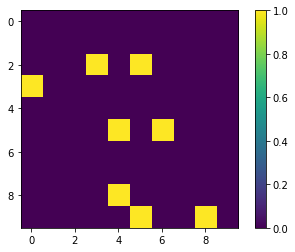

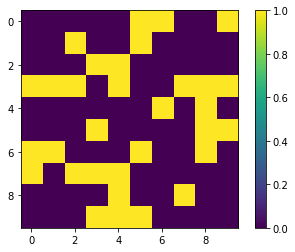

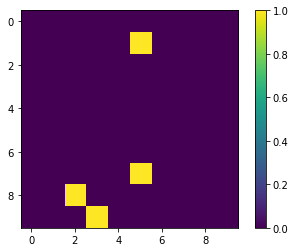

In [7]:
for t in range(20):
    plt.figure()
    plt.imshow(S[t])
    plt.colorbar()
    plt.show()
    plt.figure()
    plt.imshow(S[t+1]!=S[t])
    plt.colorbar()
    plt.show()

# Load data

In [4]:
npzfile = np.load('./data/er01.npz')
_X, _Y = npzfile['_X'], npzfile['_Y']

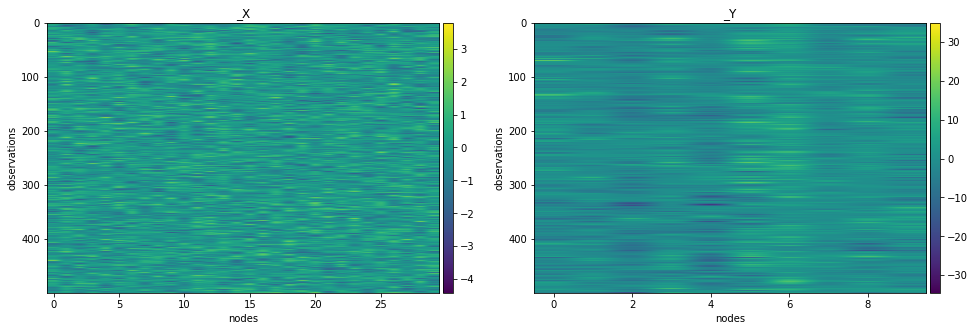

In [5]:
fig, axs = plt.subplots(1,2,figsize=(8*2,2))
axs = axs.reshape(-1,)
for i, to_show in enumerate('_X, _Y'.split(', ')):
    val = eval(to_show)
    im = axs[i].imshow(val)
    axs[i].set_aspect('auto'); axs[i].set_title(to_show)
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations')
    d = make_axes_locatable(axs[i])
    cax = d.append_axes('right', size='2.5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.subplots_adjust(top=2)

In [6]:
trX0 = _X[:400].reshape(400, nodes, _d)
trY0 = _Y[:400].reshape(400, nodes, 1)

teX0 = _X[400:500].reshape(100, nodes, _d)
teY0 = _Y[400:500].reshape(100, nodes, 1)

In [7]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0), np.std(trX0, axis=0)
mu_trY0, std_trY0 = np.mean(trY0, axis=0), np.std(trY0, axis=0)

In [8]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

In [9]:
gmat0 = np.ones(nodes)-np.eye(nodes)

In [10]:
gmat0

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [11]:
adj = gmat = gmat0

In [12]:
Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (100, 10, 3)


/home/linaiqi/anaconda3/envs/dgpg/lib/python3.7/site-packages/scipy/cluster/vq.py:574: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


# DGPG

In [17]:
adj = adj.astype('float64')
# input_adj = np.ones_like(adj) # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trY, Z, [3], Gaussian(), adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=20, minibatch_size=20
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (3(agg:30)->1)
func __init__ consumed 1.1s


In [18]:
%%time

session = m_dgpg.enquire_session()
global_step = mon.create_global_step(session)

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

with mon.LogdirWriter('./model-tensorboard/rwp-vanilla') as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task] # [print_task, tensorboard_task]

    optimiser = gpflow.train.AdamOptimizer(0.001)
    
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=6000)

Tasks execution time summary:
tensorboard:	1.0975 (sec)
CPU times: user 2min 51s, sys: 29.6 s, total: 3min 21s
Wall time: 3min 52s


In [19]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()  #trX[0:60], trY[0:60]
sample_X, sample_Y = teX, teY.squeeze()  #trX[0:60], trY[0:60]
S = 200  # sample_X.shape[0]*10
m, v = model.predict_y(sample_X.reshape(sample_X.shape[0], -1), S)
predY, predVY = np.mean(m, axis=0).squeeze(), np.mean(v, axis=0)

In [20]:
predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

metrics:	[mae, rmse, mape]
ours DGP:	 [3.922, 5.501, 2.75]
yesterday:	 [4.418, 6.169, 3.944]
day-mean:	 [4.328, 6.114, 4.266]
day_median:	 [4.331, 6.111, 4.206]


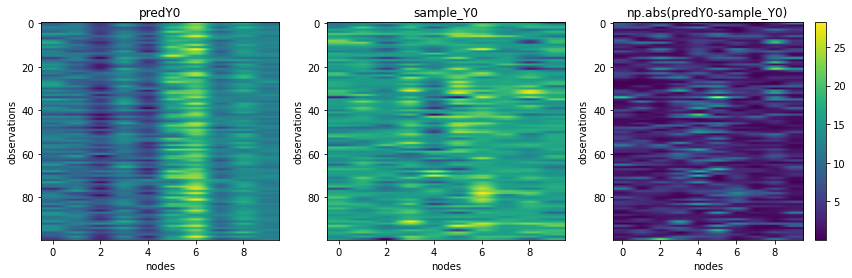

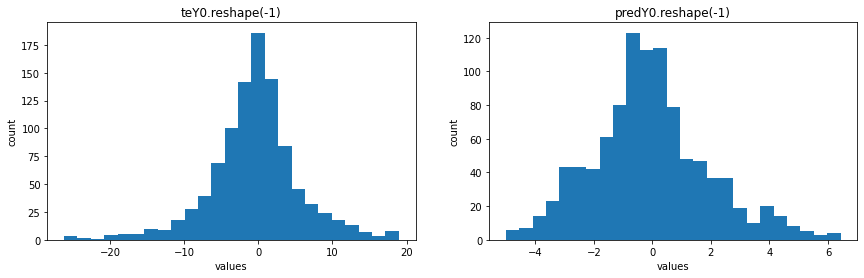

In [21]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0.mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0, axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae, rmse, mape]')
print('ours DGP:\t', e_dgp)
print('yesterday:\t', e_last)
print('day-mean:\t', e_ha)
print('day_median:\t', e_mid)

# visualization of prediction(mean)
fig, axs = plt.subplots(1, 3)
max_val = sample_Y0.max()*1.1
for i, to_show in enumerate('predY0,sample_Y0,np.abs(predY0-sample_Y0)'.split(',')):
    im = axs[i].imshow(eval(to_show))
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations');
fig.colorbar(im, ax=axs[-1])
plt.subplots_adjust(right=2)
plt.show()

# visualization of variance
fig, axs = plt.subplots(1, 2)
for i, to_show in enumerate('teY0.reshape(-1),predY0.reshape(-1)'.split(',')):
    im = axs[i].hist(eval(to_show), bins=25)
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('values'); axs[i].set_ylabel('count');
plt.subplots_adjust(right=2)
plt.show()

# TWDGPG

In [13]:
trX = np.concatenate((trX, teX))

trY = np.concatenate((trY, teY))

In [14]:
adj = adj.astype('float64')
time_vec = np.arange(trX.shape[0])

with gpflow.defer_build():
    m_dgpg = TWDGPG(trX, trY, Z, time_vec, [3], Gaussian(), adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=20, minibatch_size=20,
                  #kern_type='Matern32', 
                  kern_type='RBF', 
#                   kern_type='Poly1', 
                  #wfunc='logi'
                  wfunc='krbf'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (3(agg:30)->1)
2
func __init__ consumed 1.2s


In [15]:
session = m_dgpg.enquire_session()
# optimiser = gpflow.train.ScipyOptimizer()
global_step = mon.create_global_step(session)

Zcp = model.layers[0].feature.Z.value.copy()

In [16]:
cc=300
maxiter=6000

In [ ]:
model.X.update_cur_n(0,cc=cc)
model.Y.update_cur_n(0,cc=cc)

pred_res, var_res = [], []

exp_path="./exp/tmp-cc%d" % int(cc)
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

# nw = np.zeros((trX.shape[0]-1, nodes, nodes))
# nw[0, :, :] = model.layers[0].kern.lengthscales.value

for cur_n in range(399, trX.shape[0]-1):
# for cur_n in range(1, trX.shape[0]):
    print(cur_n)
    model.X.update_cur_n(cur_n,cc=cc)
    model.Y.update_cur_n(cur_n,cc=cc)
    optimiser = gpflow.train.AdamOptimizer(0.001)
    with mon.LogdirWriter(exp_path) as writer:
        tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
            .with_name('tensorboard')\
            .with_condition(mon.PeriodicIterationCondition(100))\
            .with_exit_condition(True)
        monitor_tasks = [] # [print_task, tensorboard_task]

        with mon.Monitor(monitor_tasks, session) as monitor:
            #optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)
            model.layers[0].feature.Z.assign(Zcp.copy())
            model.layers[0].kern.lengthscales.assign(np.ones((nodes, nodes*_d)))
            optimiser.minimize(model, step_callback=monitor, maxiter=maxiter)
#             nw[cur_n, :, :] = model.layers[0].kern.lengthscales.value
            
    teX = trX[cur_n+1].reshape(1, nodes*_d)

    S=100
    m, v = model.predict_y(teX, S)
    predY = np.mean(m, axis=0)
    pred = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()
    gt = unnormalize_data(trY[cur_n+1], mu_trY0, std_trY0).squeeze()
#     var = np.mean(v, axis=0)

    pred_res.append(pred)
#     var_res.append(var)
    print('STEP %d - loss: %f' % (cur_n, np_rmse(pred, gt)))

399
STEP 399 - loss: 5.172399
400
STEP 400 - loss: 4.923123
401
STEP 401 - loss: 5.443631
402
STEP 402 - loss: 5.050895
403
STEP 403 - loss: 2.782118
404
STEP 404 - loss: 5.229448
405
STEP 405 - loss: 6.709690
406
STEP 406 - loss: 3.406983
407
STEP 407 - loss: 6.994881
408
STEP 408 - loss: 8.459048
409
STEP 409 - loss: 2.365661
410
STEP 410 - loss: 2.887195
411
STEP 411 - loss: 6.014120
412
STEP 412 - loss: 5.971721
413
STEP 413 - loss: 3.059126
414
STEP 414 - loss: 4.285857
415
STEP 415 - loss: 9.084988
416
STEP 416 - loss: 3.260386
417
STEP 417 - loss: 7.591839
418
STEP 418 - loss: 3.030377
419
STEP 419 - loss: 5.795923
420
STEP 420 - loss: 11.012665
421
STEP 421 - loss: 2.750692
422
STEP 422 - loss: 5.744355
423
STEP 423 - loss: 3.765315
424
STEP 424 - loss: 6.003451
425
STEP 425 - loss: 2.667331
426
STEP 426 - loss: 4.437343
427
STEP 427 - loss: 3.115292
428
STEP 428 - loss: 6.427778
429
STEP 429 - loss: 3.676898
430
STEP 430 - loss: 8.862262
431
STEP 431 - loss: 7.751532
432
STEP 

In [21]:
predY0 = np.asarray(pred_res)

In [22]:
sample_Y0 = teY0.squeeze()

metrics:	[mae, rmse, mape]
ours DGP:	 [3.849, 5.344, 2.58]


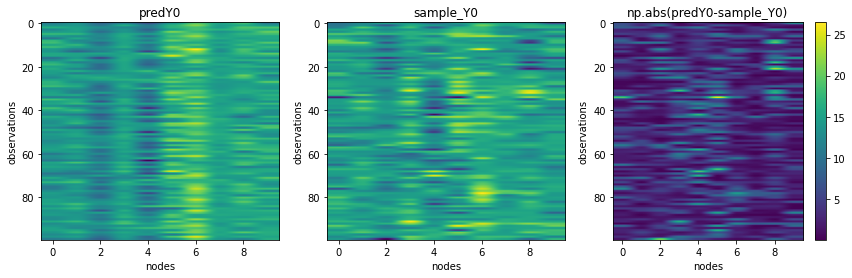

In [23]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
# e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
# e_ha = [np.round(f(sample_X0.mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
# e_mid = [np.round(f(np.median(sample_X0, axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae, rmse, mape]')
print('ours DGP:\t', e_dgp)
# print('yesterday:\t', e_last)
# print('day-mean:\t', e_ha)
# print('day_median:\t', e_mid)

# visualization of prediction(mean)
fig, axs = plt.subplots(1, 3)
max_val = sample_Y0.max()*1.1
for i, to_show in enumerate('predY0,sample_Y0,np.abs(predY0-sample_Y0)'.split(',')):
    im = axs[i].imshow(eval(to_show))
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations');
fig.colorbar(im, ax=axs[-1])
plt.subplots_adjust(right=2)
plt.show()

# baselines

In [22]:
from sklearn.linear_model import LinearRegression

lr_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    lr = LinearRegression()
    m = lr.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    lr_pred0[:, k, 0] = predy

lr_predY = unnormalize_data(lr_pred0, mu_trY0, std_trY0)

In [23]:
from sklearn.svm import SVR

svr_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    svr = SVR(kernel='rbf')
    m = svr.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    svr_pred0[:, k, 0] = predy

svr_predY = unnormalize_data(svr_pred0, mu_trY0, std_trY0)

In [24]:
from sklearn import tree

tree_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    ttree = tree.DecisionTreeRegressor(random_state=0, max_depth=3)
    m = ttree.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    tree_pred0[:, k, 0] = predy

tree_predY = unnormalize_data(tree_pred0, mu_trY0, std_trY0)

In [25]:
from sklearn.neural_network import MLPRegressor

mlp_pred0 = np.zeros(teY.shape)

for k in range(gmat.shape[1]):
    idx = (gmat[k, :] == 1)
    regx = trX[:, idx, :]
    regx = regx.reshape(regx.shape[0], -1)
    regy = trY[:, k, :].reshape(-1)
    
    mlp_ = MLPRegressor(hidden_layer_sizes=(100, 100))
    m = mlp_.fit(regx, regy)
    
    predx = teX[:, idx, :]
    predx = predx.reshape(predx.shape[0], -1)    
    predy = m.predict(predx)
    
    mlp_pred0[:, k, 0] = predy

mlp_predY = unnormalize_data(mlp_pred0, mu_trY0, std_trY0)

In [26]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()  #trX[0:60], trY[0:60]
sample_X, sample_Y = teX, teY.squeeze()  #trX[0:60], trY[0:60]

In [27]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_lr = [np.round(f(lr_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
e_svr = [np.round(f(svr_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
e_tree = [np.round(f(tree_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
e_mlp = [np.round(f(mlp_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('LR:\t', e_lr)
print('SVR:\t', e_svr)
print('TREE:\t', e_tree)
# print('MLP:\t', e_mlp)
# print('day-mean:\t', e_ha)
# print('day_median:\t', e_mid)

metrics:	[mae | rmse | mape]
LR:	 [4.137, 5.636, 2.385]
SVR:	 [4.0, 5.591, 2.634]
TREE:	 [4.284, 6.025, 2.72]


# time weighted baselines

In [28]:
time_vec = np.arange(500)

In [29]:
def get_weight(cur_n, cc):
    cur_time = time_vec[cur_n]
    w = np.zeros((500, ))

    for i in range(cur_n+1):
        w[i] = ((cur_time - time_vec[i]) / cc) ** 2
    for i in range(cur_n+1):
        w[i] = np.exp(-w[i])
    w = w / np.sum(w)   
    return w

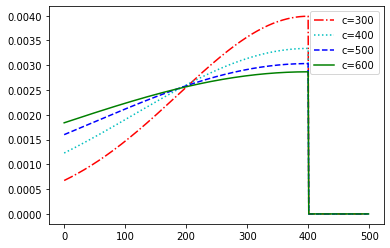

In [30]:
# plt.plot(get_weight(400, cc=100), 'b--', label='c=100')
# plt.plot(get_weight(400, cc=200), 'g-', label='c=200')
plt.plot(get_weight(400, cc=300), 'r-.', label='c=300')
plt.plot(get_weight(400, cc=400), 'c:', label='c=400')
plt.plot(get_weight(400, cc=500), 'b--', label='c=500')
plt.plot(get_weight(400, cc=600), 'g-', label='c=600')
plt.legend()

In [31]:
cc=300

In [32]:
twlr_pred0 = np.zeros(teY.shape)

for t in range(400-1, 500-1):
    w = get_weight(t, cc)[:t]

    for k in range(gmat.shape[1]):
        idx = (gmat[k, :] == 1)
        regx = _X.reshape(-1, nodes, _d)[:t, idx, :]
        regx = regx.reshape(regx.shape[0], -1)
        regy = _Y.reshape(-1, nodes, 1)[:t, k, :].reshape(-1)

        twlr = LinearRegression()
        m = twlr.fit(regx, regy, sample_weight=w)

        predx = _X.reshape(-1, nodes, _d)[t+1, idx, :]
        predx = predx.reshape(1, -1)    
        predy = m.predict(predx)

        twlr_pred0[t-399, k, 0] = predy

twlr_predY = twlr_pred0

In [33]:
twsvr_pred0 = np.zeros(teY.shape)

for t in range(400-1, 500-1):
    w = get_weight(t, cc)[:t]

    for k in range(gmat.shape[1]):
        idx = (gmat[k, :] == 1)
        regx = _X.reshape(-1, nodes, _d)[:t, idx, :]
        regx = regx.reshape(regx.shape[0], -1)
        regy = _Y.reshape(-1, nodes, 1)[:t, k, :].reshape(-1)

        twsvr = SVR()
        m = twsvr.fit(regx, regy, sample_weight=w)

        predx = _X.reshape(-1, nodes, _d)[t+1, idx, :]
        predx = predx.reshape(1, -1)    
        predy = m.predict(predx)

        twsvr_pred0[t-399, k, 0] = predy

twsvr_predY = twsvr_pred0

In [34]:
twtree_pred0 = np.zeros(teY.shape)

for t in range(400-1, 500-1):
    w = get_weight(t, cc)[:t]

    for k in range(gmat.shape[1]):
        idx = (gmat[k, :] == 1)
        regx = _X.reshape(-1, nodes, _d)[:t, idx, :]
        regx = regx.reshape(regx.shape[0], -1)
        regy = _Y.reshape(-1, nodes, 1)[:t, k, :].reshape(-1)

        twtree = tree.DecisionTreeRegressor()
        m = twtree.fit(regx, regy, sample_weight=w)

        predx = _X.reshape(-1, nodes, _d)[t+1, idx, :]
        predx = predx.reshape(1, -1)    
        predy = m.predict(predx)

        twtree_pred0[t-399, k, 0] = predy

twtree_predY = twtree_pred0

In [35]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_lr = [np.round(f(twlr_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
e_svr = [np.round(f(twsvr_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
e_tree = [np.round(f(twtree_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
# e_mlp = [np.round(f(mlp_predY.squeeze(), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('LR:\t', e_lr)
print('SVR:\t', e_svr)
print('TREE:\t', e_tree)
# print('MLP:\t', e_mlp)
# print('day-mean:\t', e_ha)
# print('day_median:\t', e_mid)

metrics:	[mae | rmse | mape]
LR:	 [4.066, 5.525, 2.312]
SVR:	 [4.11, 5.812, 3.284]
TREE:	 [5.186, 7.116, 2.077]
